In [1]:
from zemax_wfe import *

In [2]:
zos = PythonStandaloneApplication()

# load local variables
ZOSAPI = zos.ZOSAPI
TheApplication = zos.TheApplication
TheSystem = zos.TheSystem

In [3]:
# === USER CONFIGURATION ===
base_folder = rf"C:\Users\abocc\OneDrive - uniroma1.it\Andrea\work\Sap\Projects\zemax"
sim_config = "FC"
# case_number = '17'
case_number = "01"
zemax_filename = f"ARIEL - STOP Analysis - {sim_config} - C{case_number}"
zemax_file_path = (
    rf"{base_folder}\{zemax_filename}.zmx"  # Change to your .ZMX or .ZOS file path
)
# surface_number = 69  # Surface where you want the wavefront map

# === Load the file ===
zos.OpenFile(zemax_file_path, False)

In [4]:
# Get the wavelength data
wavelength_data = TheSystem.SystemData.Wavelengths

custom_wavelength_um = 0.633
# Process wavelength selection
if custom_wavelength_um is not None:
    # Add a new wavelength
    wavelength_data.GetWavelength(1).Wavelength = custom_wavelength_um

In [5]:
# === Setup Wavefront Map Analysis ===
analysis = TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap)

In [6]:
lens_data = TheSystem.LDE
surface_found = False
surface_number = -1

surface_name = "EXPP"
for i in range(1, lens_data.NumberOfSurfaces):
    surface = lens_data.GetSurfaceAt(i)
    comment = surface.Comment
    #print(comment)
    if comment.upper() == surface_name:
        surface_number = i
        surface_found = True
        print(
            f"Found surface with comment '{comment}' at surface number {surface_number}"
        )
        break

Found surface with comment 'EXPP' at surface number 69


In [20]:
# Explicitly cast to IAS_WavefrontMap settings
settings = analysis.GetSettings()
wavefront_settings = ZOSAPI.Analysis.Settings.IAS_WavefrontMap(settings)

# Now set the surface number on the properly cast object
wavefront_settings.Surface.SetSurfaceNumber(surface_number)

# Set the grid resolution to 64x64
wavefront_settings.Sampling = ZOSAPI.Analysis.SampleSizes.S_512x512

In [21]:
# Apply the settings and run the analysis
analysis.ApplyAndWaitForCompletion()

In [25]:
# Get results
results = analysis.GetResults()

In [ ]:
# Save to txt file
out_dir = "WavefrontOutputs"
results.GetTextFile(f"{base_folder}\\{out_dir}\\{zemax_filename}.txt")

True

In [27]:
data_grid = results.GetDataGrid(0)

# Use get_Values() to retrieve the actual grid data
grid_data = data_grid.get_Values()

# For reshaping and processing the data
x_size = grid_data.GetLength(0)  # X dimension
y_size = grid_data.GetLength(1)  # Y dimension

# Now, you can reshape the data if needed
reshaped_data = zos.reshape(grid_data, x_size, y_size)
wfe_map = np.asarray(reshaped_data)

In [28]:
wavelength_data = TheSystem.SystemData.Wavelengths
wavelength_um = wavelength_data.GetWavelength(1).Wavelength  # in microns

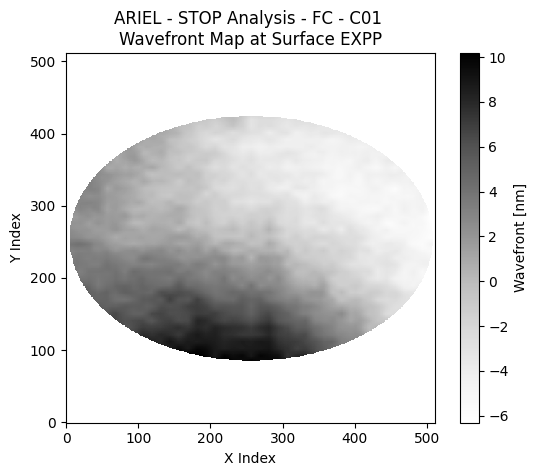

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(wfe_map * wavelength_um * 1e3, cmap="Greys", origin="lower", interpolation="none")
plt.colorbar(label="Wavefront [nm]")
plt.title(f"{zemax_filename} \nWavefront Map at Surface {surface_name}")
plt.xlabel("X Index")
plt.ylabel("Y Index")
plt.show()

In [30]:
# Optional: Close the file
zos.CloseFile(False)

#

# This will clean up the connection to OpticStudio.
# Note that it closes down the server instance of OpticStudio, so you for maximum performance do not do
# this until you need to.
del zos
zos = None